In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import matplotlib.pyplot as plt
import torch
from collections import OrderedDict
sys.path.append('..')
sys.path.append('../../simplebev_org/simple_bev')

/kuacc/users/mbarin22/.conda/envs/mask2former/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_feats = torch.load('/kuacc/users/mbarin22/hpc_run/mask2former4bev/scripts/train_features1.pt')['features']
val_feats = torch.load('/kuacc/users/mbarin22/hpc_run/mask2former4bev/scripts/val_features0.pt')['features']

In [4]:
train_feats.shape , val_feats.shape

(torch.Size([6, 128, 56, 100]), torch.Size([6, 128, 56, 100]))

In [10]:
train_feats[5][0], val_feats[0][0]

(tensor([[-0.1790, -0.1809, -0.6387,  ..., -0.4426, -0.4675,  0.0377],
         [-0.4902, -0.6079, -0.1766,  ..., -0.5630, -0.3174, -0.5464],
         [-0.9395, -0.2546, -0.3564,  ...,  0.3987,  0.1320, -0.3613],
         ...,
         [-0.1486, -0.8853, -0.3152,  ..., -0.8730, -0.5542, -0.1842],
         [-0.7324, -0.2751,  0.1979,  ..., -1.1748, -0.5381, -0.2935],
         [-0.4658, -0.6895, -0.4309,  ..., -0.9487, -0.3013, -0.2239]],
        device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>),
 tensor([[-0.1801,  0.0553, -0.4524,  ..., -0.1664, -0.1512,  0.1095],
         [-0.2925,  0.0085, -0.4529,  ..., -0.6133, -0.2236, -0.5327],
         [-0.3406, -0.1810, -0.4399,  ..., -0.4402, -0.1650,  0.2208],
         ...,
         [-0.3569, -0.9351, -0.5054,  ..., -0.2930,  0.2839, -0.0400],
         [ 0.0018, -0.1142, -0.4016,  ..., -0.2330, -0.2054, -0.4307],
         [-0.3655, -1.3965, -0.6377,  ..., -0.7739, -0.3372, -0.3994]],
        device='cuda:0', dtype=torch.float16

In [3]:
class Arguments:

    def __init__(self):
        
        
        self.is_loss_weights_param = 0
        self.project = 'mask2former4bev'
        self.model_name = 'detr4bev'
        self.dataset_path = '/datasets/nuscenes'
        self.version = 'trainval'

        # write all the parameters like above
        self.res_scale = 1
        self.H = 1600
        self.W = 900
        self.rand_crop_and_resize = 0
        
        self.resize_to = [448,800]
        self.crop_offset = 0
        self.random_flip = 0
        self.resize_lim = [1.0, 1.0]
        self.cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
        self.ncams = 6

        self.do_shuffle_cams = 0
        self.refcam_id = 1

        self.backbone = "res101-simplebev"
        self.freeze_backbone = 0
        self.patch_size = 16

        self.mask_classification = 1
        self.class_weight = 1.0
        self.dice_weight = 1.0
        self.mask_weight = 20.0
        self.no_object_weight = 0.1
        self.deep_supervision = 1

        self.train_num_points = 112*112
        self.oversample_ratio = 3.0
        self.importance_sample_ratio = 0.75

        self.sem_seg_head_name = 'detr_head'
        self.transformer_in_feature = 'multi_scale_bev_features'

        self.bev_module_name = 'SimpleBEV'
        self.bev_latent_dim = 128
        self.multiscale_feature_channels = [64, 128, 256]
        self.multiscale_feature_norm = 'batch'
        self.multiscale_conv_dim = 256
        self.voxel_size = [200, 8, 200]
        self.bounds = [-50, 50, -5, 5, -50, 50]
        self.do_rgb_compress = 1

        self.use_frozen_bev_feats = 0
        self.frozen_bev_feats_path = '/kuacc/users/mbarin22/hpc_run/mask2former4bev/checkpoints/simplebev/8x5_5e-4_rgb12_22:43:46/model-000025000.pth'

        self.num_classes = 1

        self.predictor_type = 'TransformerPredictor'
        self.nheads = 8
        self.dec_layers = 6
        self.pe_hidden_dim = 256
        self.predictor_dropout = 0
        self.num_queries = 50
        self.pre_norm = 0
        self.dim_feedforward = 2048
        self.enforce_input_project = 0
        self.mask_dim = 256
        
        self.use_multiscale_features = 1
        self.rt_regression = 0
        self.translation_weight =1
        self.heading_weight = 1

        self.use_lidar = 1

        self.decoder_type = 'conv'

        self.learning_rate = 4e-4
        self.weight_decay = 1e-7
        self.dropout = 0.0
        
        self.validate_with_gt = False


args = Arguments()

In [4]:
ckpt_path = "/kuacc/users/mbarin22/hpc_run/mask2former4bev/checkpoints/detr_[448, 800]_bs:1_nq:50_10k_0.0001_overfit/epoch_2800.pt"

In [5]:
from dataset import NuScenesDatasetWrapper

datamodule = NuScenesDatasetWrapper(args)

Loading NuScenes version trainval from /datasets/nuscenes
Done loading NuScenes version trainval


In [15]:
from models.mask2former4bev import DETR4BEV

model = DETR4BEV(args).cuda()
loaded_model = OrderedDict((key.replace('module.', ''), value) for key, value in torch.load(ckpt_path)["model"].items()) 

model.load_state_dict(loaded_model,strict=True)
model.eval()

idx: 0, in_channels: 64
idx: 1, in_channels: 128
idx: 2, in_channels: 256
lateral_convs 0: None
lateral_convs 1: Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
lateral_convs 2: Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
output_convs 0: Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
output_convs 1: Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)
output_convs 2: Sequential(
  (0): Conv2d(256, 256, kernel_size

DETR4BEV(
  (backbone): SimpleBEVEncoder(
    (encoder): Encoder_res101(
      (backbone): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [9]:
valset = datamodule.val()
trainset = datamodule.train()

is_train False
is_train True


In [19]:
idx = 12485
batch = trainset[idx] #valset[idx]
preds = model([batch]) #, training=False) 

pred_logits tensor([[[0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139, 0.2861],
         [0.7139

In [12]:
batch.keys()

dict_keys(['images', 'rots', 'trans', 'intrins', 'seg_bev', 'valid_bev', 'center_bev', 'offset_bev', 'ego_pose', 'multi_seg_bev', 'gt_masks', 'multi_valid_bev', 'gt_valid', 'translation_rotation_list'])

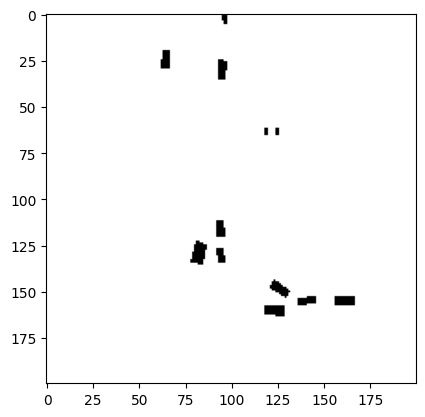

In [30]:
plt.imshow(batch['gt_masks'][0]*batch['gt_valid'][0], cmap='binary')

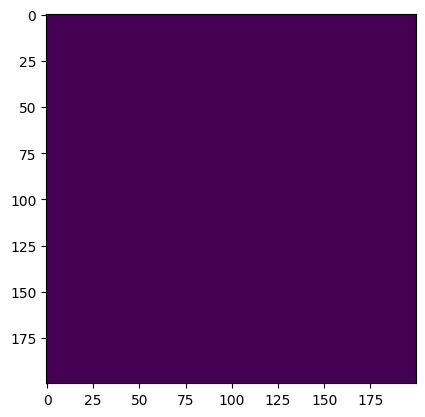

In [31]:
plt.imshow(preds[0]['pred_masks'][0].detach().cpu())

In [46]:
from torch.nn import functional as F
F.softmax(preds[0]['pred_logits'].unsqueeze(0), dim=-1)[:, :, :-1].max(-1)[1]

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]], device='cuda:0')

In [39]:
bb = preds[0]['pred_boxes'][15]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

box_xyxy = box_cxcywh_to_xyxy(bb)  # num_queries, 4
box_xyxy[0] = box_xyxy[0]*200     # x min
box_xyxy[1] = box_xyxy[1]*200     # y min
box_xyxy[2] = box_xyxy[2]*200     # x max
box_xyxy[3] = box_xyxy[3]*200     # y max

In [40]:
box_xyxy

tensor([ 98.5221,  69.9092, 110.9640,  86.4210], device='cuda:0',
       grad_fn=<CopySlices>)